<h1><span style="color:orange">The ORANGE exercise</span></h1>

Patterns from each of ***two classes have been drawn from different distributions***. I.e. there is a true difference between them. However, a simple classification has been run, and the ***classifier has returned an accuracy quite close to chance***. 

***Is there a problem? Is there a simple way to improve the analysis to increase the classification score?***


## Getting ready

Import the packages we might need:

In [10]:
import numpy as np # This lets python process matrices, like Matlab
import matplotlib.pyplot as plt # This lets python plot graphs like Matlab

# scikit-learn is the major library for machine learning in Python:
import sklearn as skl
from sklearn import preprocessing # includes LabelEncoder, OneHotEncoder, StandardScaler...
from sklearn import model_selection # includes StratifiedKFold, LeaveOneGroupOut...
from sklearn import linear_model # includes LogisticRegression, RidgeClassifier...
from sklearn import svm # includes SVC, NuSVC & LinearSCV...
from sklearn import discriminant_analysis # includes LinearDiscriminantAnalysis
from sklearn import metrics # includes roc_auc_score...
from sklearn import pipeline # includes make_pipeline

Set the random number generator:

In [11]:
np.random.seed(1)

## Simulate some data with a true difference between conditions:

In [27]:
nvox = 2 # number of voxels
nruns= 6 # number of runs
n_samples_per_run = 20 # number of samples/patterns per run; these will be divided into conditions/classes "0" and "1"
proportion_of_samples_from_condition_0 = 0.8

mu0 = np.arange(nvox) # mean activation for condition 0 (voxels all have different activation strength)
mu1 = np.roll(mu0, 1) # mean activation for condition 1 (same overall activity, but distributed differently across voxels)
voxel_covariance0 = np.diag(mu0) + 1 # voxel covariance: independent noise per voxel is proportional to mean, plus some covariance
voxel_covariance1 = np.diag(mu1) + 1 # voxel covariance: independent noise per voxel is proportional to mean, plus some covariance

data_per_run = []   # list of pattern matrices (one for each run)
labels_per_run = []    # list of label vectors (one for each run)
for r in np.arange(nruns):
    # label each sample as condition 0 or 1 (the +0 is a trick to convert the logical values to integers):
    label_vector= ((np.arange(n_samples_per_run)/n_samples_per_run)>=proportion_of_samples_from_condition_0)+0;
    
    # sample activations from each distribution:
    data_matrix0 =  np.random.multivariate_normal(mu0, voxel_covariance0, size=np.sum(label_vector==0))
    data_matrix1 =  np.random.multivariate_normal(mu1, voxel_covariance1, size=np.sum(label_vector==1))
    data_matrix  =  np.concatenate((data_matrix0, data_matrix1))
    
    data_per_run.append( data_matrix ) 
    labels_per_run.append( label_vector ) 

# concatenate runs
data        = np.concatenate(data_per_run, axis=0)             
labels      = np.concatenate(labels_per_run, axis=0)
run_indices = np.concatenate([[i] * n_samples_per_run for i in range(nruns)])

\
Plot the data for the first two voxels:

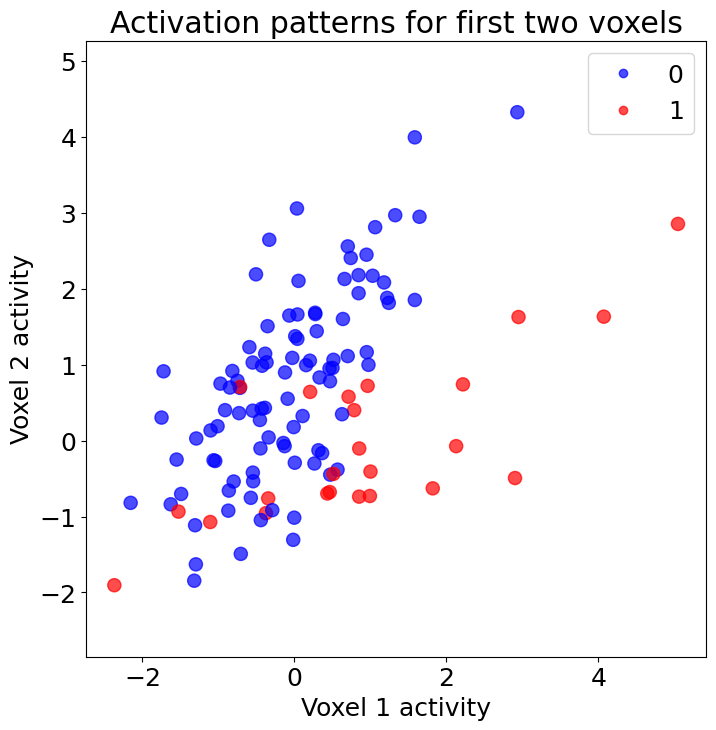

In [28]:
plt.figure(figsize=(8,8))  # create a matplotlib figure
plt.title('Activation patterns for first two voxels')
scatter = plt.scatter(data[:,[0]], data[:,[1]], 
                      s= 90, alpha=0.7, c=labels, cmap='bwr')
plt.legend(handles=scatter.legend_elements()[0], labels=set(np.unique(labels))) # "set" returns unique values
plt.xlabel('Voxel 1 activity')
plt.ylabel('Voxel 2 activity')
plt.rcParams.update({'font.size': 18})
plt.axis('equal')
plt.show()

\
Specify the pre-processing, classification pipeline, and a leave-one-run-out cross-validation scheme:

In [29]:
scaler = skl.preprocessing.MinMaxScaler()
SVM    = skl.svm.LinearSVC(dual=True)
pipe   = skl.pipeline.make_pipeline(scaler, SVM)
logo   = skl.model_selection.LeaveOneGroupOut()

\
Run the classification analysis:

In [30]:
accuracy = skl.model_selection.cross_val_score(pipe, data, labels, groups  = run_indices, cv = logo, scoring = 'balanced_accuracy')

print("Accuracy per fold:", accuracy)
print("Mean accuracy for data with a true difference between conditions:", np.mean(accuracy))

Accuracy per fold: [0.625 0.75  0.5   0.75  0.75  0.75 ]
Mean accuracy for data with a true difference between conditions: 0.6875


The classifier has returned an accuracy quite close to chance. 

Is there a problem? Is there a simple way to improve the analysis to increase the classification score?

## A possible answer

The dataset is very unbalanced, i.e. there are more samples in one class than the other. This means that a naive classifier will be biased to select the over-represented class, more often than would be optimal.

The performance metric used here (balanced accuracy) is unbiased, but is unable to counteract the reduced sensitivity caused by the bias in the classifier. To force the classifier to learn the relevant information (voxel activation pattern differences) and to ignore the irrelevant information (sample proportions), set `class_weight='balanced'` when creating the classifier object. A  more involved solution could be to sub-sample the over-represented class to make the classes balanced (see the RED exercise for a way this might be implemented). 

Extension: Imbalance tends to be more problematic when spuriously inflating classification performance (see the RED exercise), than when reducing senstitivity to a true effect, because imbalance typically needs to be quite extreme to swamp the true information in the patterns. Explore this by ensuring that `class_weight='balanced'` is NOT set, and by changing the proportion of samples that come from class "0".